### Versión funcional del [`algoritmo de shor`](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/shor_algorithm.ipynb) en la versión actual
Se hicieron cambios en la estructura del codigo para dejarlo en funcionando en la versión de qiskit 2.0.2, que era lo requerido en la entrega, principalmente en las importaciones, como transpile que ahora esta en el modulo principal, también para adaptarase a cambios como el de la compuerta u1.

In [69]:
import math

import pandas as pd
import numpy as np
import random

from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator

from math import gcd
from fractions import Fraction

In [78]:
import qiskit
print(qiskit.__version__)

2.0.2


In [92]:
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11:
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

In [93]:
def circuit_aperiod15(qc, qr, cr, a):
    qc.x(qr[0])
    
    qc.h(qr[4])
    qc.h(qr[4])
    qc.measure(qr[4], cr[0])
    qc.reset(qr[4])
    
    qc.h(qr[4])
    qc.cx(qr[4], qr[2])
    qc.cx(qr[4], qr[0])

    # https://docs-quantum-ibm-com.translate.goog/api/qiskit/qiskit.circuit.library.U1Gate?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc&_x_tr_hist=true
    qc.p(math.pi/2.0, qr[4])
    qc.if_test((cr, 1), None)
    
    qc.h(qr[4])
    qc.measure(qr[4], cr[1])
    qc.reset(qr[4])
    
    qc.h(qr[4])
    circuit_amod15(qc, qr, cr, a)
    
    qc.p(3.*math.pi/4., qr[4])
    qc.if_test((cr, 3), None)
    
    qc.p(math.pi/2., qr[4])
    qc.if_test((cr, 2), None)
    
    qc.p(math.pi/4., qr[4])
    qc.if_test((cr, 1), None)
    
    qc.h(qr[4])
    qc.measure(qr[4], cr[2])

In [151]:
def get_factors(measured_phases, a, N=15):
    factors_found = []
    
    for phase in measured_phases:
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        
        if r % 2 == 0:
            guesses = [gcd(a**(r//2) - 1, N), gcd(a**(r//2) + 1, N)]
            
            for guess in guesses:
                if guess not in [1, N] and guess not in factors_found:
                    if N % guess == 0:
                        factors_found.append(guess)
                        factors_found.append(N // guess)
    
    factors_found = sorted(list(set(factors_found)))
    
    return factors_found

In [95]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

a = 7

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor, q, c, a)

shor.draw(fold=-1)

┌───┐                       ┌───┐                                                    ┌───┐                                       
q_0: ┤ X ├───────────────────────┤ X ├─────────────────────────────X──────────────────────┤ X ├───────────────────────────────────────
     └───┘                       └─┬─┘                             │                 ┌───┐└─┬─┘                                       
q_1: ──────────────────────────────┼───────────────────────────────X──X──────────────┤ X ├──┼─────────────────────────────────────────
                            ┌───┐  │                               │  │         ┌───┐└─┬─┘  │                                         
q_2: ───────────────────────┤ X ├──┼───────────────────────────────┼──X──X──────┤ X ├──┼────┼─────────────────────────────────────────
                            └─┬─┘  │                               │  │  │ ┌───┐└─┬─┘  │    │                                         
q_3: ─────────────────────────┼────┼───────────────────────────────┼──┼──X─┤ X ├──┼────┼────┼─────────────────────────────────────────
     ┌───┐┌───┐┌─┐     ┌───┐  │    │  ┌────────┐┌───┐┌─┐     ┌───┐ │  │  │ └─┬─┘  │    │    │  ┌─────────┐┌────────┐┌────────┐┌───┐┌─┐
q_4: ┤ H ├┤ H ├┤M├─|0>─┤ H ├──■────■──┤ P(π/2) ├┤ H ├┤M├─|0>─┤ H ├─■──■──■───■────■────■────■──┤ P(3π/4) ├┤ P(π/2) ├┤ P(π/4) ├┤ H ├┤M├
     └───┘└───┘└╥┘     └───┘          └────────┘└───┘└╥┘     └───┘                             └─────────┘└────────┘└────────┘└───┘└╥┘
c: 5/═══════════╩═════════════════════════════════════╩═════════════════════════════════════════════════════════════════════════════╩═
                0                                     1                                                                             2

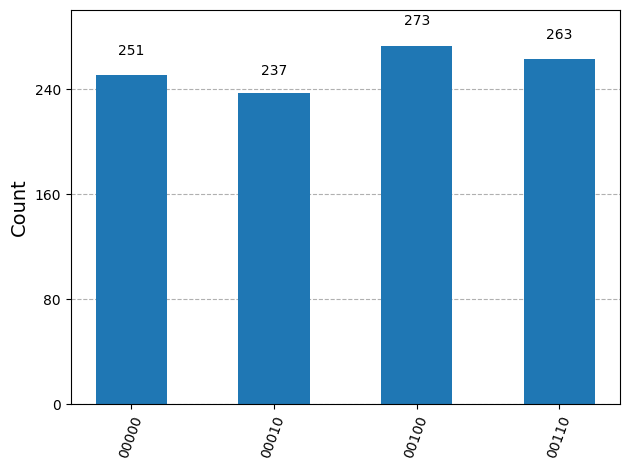

In [96]:
N_COUNT = 3

simulator = AerSimulator()
t_shor = transpile(shor, simulator)
counts = simulator.run(t_shor).result().get_counts()
plot_histogram(counts)

In [97]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)
    phase = decimal/(2**N_COUNT)
    measured_phases.append(phase)
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

         Register Output       Phase
0  00100(bin) =   4(dec)  4/8 = 0.50
1  00000(bin) =   0(dec)  0/8 = 0.00
2  00010(bin) =   2(dec)  2/8 = 0.25
3  00110(bin) =   6(dec)  6/8 = 0.75


In [98]:
factors = get_factors(measured_phases, a, N=15)

if factors:
    product = 1
    for factor in factors:
        product *= factor
        print(f"Factor: {factor}")

Factor: 3
Factor: 5


### Versión adicional del [`algoritmo de shor`](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb)
Adicionalmente y para el posterior intento de implementación general, hay una implementación del algoritmo que me parece mucho más clara y más entendible para mi, ya que es esta la que encontre y entendí en videos y otras fuentes de información, la cual está acontinuación.

In [62]:
# Esta versión seguira dependiendo del N especifico, en este caso 15
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [ ]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [64]:
a = 7
N_COUNT_V2 = 8

qc = QuantumCircuit(N_COUNT_V2 + 4, N_COUNT_V2)

for q in range(N_COUNT_V2):
    qc.h(q)

qc.x(N_COUNT_V2)

for q in range(N_COUNT_V2):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT_V2 for i in range(4)])

qc.append(qft_dagger(N_COUNT_V2), range(N_COUNT_V2))

qc.measure(range(N_COUNT_V2), range(N_COUNT_V2))
qc.draw(fold=-1)

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

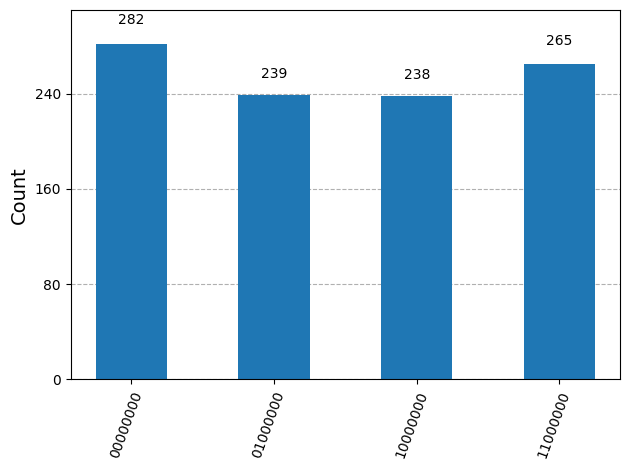

In [65]:
counts_v2 = AerSimulator().run(qc.decompose()).result().get_counts()
plot_histogram(counts_v2)

In [66]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)
    phase = decimal/(2**N_COUNT)
    measured_phases.append(phase)
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

         Register Output       Phase
0  00100(bin) =   4(dec)  4/8 = 0.50
1  00110(bin) =   6(dec)  6/8 = 0.75
2  00000(bin) =   0(dec)  0/8 = 0.00
3  00010(bin) =   2(dec)  2/8 = 0.25


In [76]:
factors = get_factors(measured_phases, a)

if factors:
    product = 1
    for factor in factors:
        print(f"Factor: {factor}")

Factor: 3
Factor: 5


### Versión general
Crear una versión general del algoritmo de shor es algo con lo que he encontrado muchos problemas incluso en libros, también hay recursos que hablan sobre como craer el circuito que represente dicho Uf, finalmente para probar una versión más general del algoritmo, lo que decidi, en vista de la complejidad de la creación de una forma cuantica general, es calcular dicha compuerta de forma clasica, esto claramente limita el número del número que podemos ingresar puesto que la principal ventaja de la versión cuantica es la reducción en la complejidad computacional.

<table>
  <tr>
    <td><img src="images/AlgoritmosCuanticos.jpg" alt="Descripción imagen 1"></td>
    <td><img src="images/Libro1.jpg" alt="Descripción imagen 2"></td>
  </tr>
</table>

In [145]:
def c_amodN(a, power, N):
    """
    Forma clasica para generar el oraculo
    """
    if gcd(a, N) != 1:
        raise ValueError(f"a={a} no es coprimo con N={N}")
    
    n_size = N.bit_length()
    
    result_classical = pow(a, power, N)
    
    dim = 2**n_size
    matrix = np.zeros((dim, dim), dtype=complex)
    
    for x in range(N):
        result = (pow(a, power, N) * x) % N
        matrix[result, x] = 1.0
    
    for i in range(N, dim):
        matrix[i, i] = 1.0
    
    op = Operator(matrix)
    
    gate = op.to_instruction()
    gate.name = f"{a}^{power} mod {N}"
    
    c_gate = gate.control(1)
    
    return c_gate

In [177]:
# N = int(input("Entre el número a factorizar N: "))
N = 39
if N > 39:
    raise ValueError("N debe ser menor o igual a 39 para evitar problemas de rendimiento.")
n_size = N.bit_length()
COUNT = 2 * n_size

coprimes = [a for a in range(2, N) if gcd(a, N) == 1]

max_attempts = 3
attempts = 0
all_factors = []

In [178]:
circuit = None
successful_a = None
all_factors = []
attempts = 0
current_coprimes = coprimes.copy()
final_counts = None

while attempts < max_attempts and not all_factors and current_coprimes:
    a = random.choice(current_coprimes)
    
    qc = QuantumCircuit(COUNT + n_size, COUNT)
    
    for q in range(COUNT):
        qc.h(q)
    
    qc.x(COUNT)
    
    for q in range(COUNT):
        qc.append(c_amodN(a, 2**q, N),
                  [q] + [i+COUNT for i in range(n_size)])
    
    qc.append(qft_dagger(COUNT), range(COUNT))
    
    qc.measure(range(COUNT), range(COUNT))
    
    simulator = AerSimulator()
    t_qc = transpile(qc, simulator)
    result = simulator.run(t_qc).result()
    counts = result.get_counts()
    
    measured_phases = []
    for output in counts:
        decimal = int(output, 2)
        phase = decimal/(2**COUNT)
        measured_phases.append(phase)
        
    factors = get_factors(measured_phases, a, N)
    
    if factors:
        all_factors = factors
        circuit = qc.copy()
        successful_a = a
        break
    else:
        current_coprimes.remove(a)  
    
    attempts += 1

if all_factors:
    for factor in all_factors:
        print(f"Factor: {factor}")

Factor: 3
Factor: 13


In [179]:
if circuit:
    print(circuit.draw(fold=-1))


      ┌───┐                                                                                                                                                                                                               ┌────────┐┌─┐                                 
 q_0: ┤ H ├───────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0       ├┤M├─────────────────────────────────
      ├───┤       │                                                                                                                                                                                                       │        │└╥┘┌─┐                              
 q_1: ┤ H ├───────┼───────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────